In [1]:
import os
import pandas as pd 
import numpy as np 
import subprocess
import math
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import dataframe_image as dfi

import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
import matplotlib.cm 
import matplotlib.colors 
plt.rcParams['font.family'] = 'Arial'

from selenobot.files import FASTAFile, fasta_file_parser_gtdb, GBFFFile, BLASTFile
from selenobot.tools import BLAST
from selenobot.gene import Gene, Genome
from selenobot.organism import Organism

%load_ext autoreload 
%autoreload 2


Based on analyzing the results of the binary model on the model organisms, it seems as though the majority of the false positives are due to the model mistakenly identifying short Prodigal artifacts and pseudogenes as truncated selenoproteins (these are the problematic false positives, because they are hard to filter without a good reference genome). It also seems prone to predicting short hypothetical proteins (which I imagine are artifacts from PGAP) to be truncated selenoproteins. In general, the model seems fairly sensitive to length, and the vast majority of the false positives are short (100-200 amino acids). Length is not the whole story, however, as many very short sequences are correctly classified as full-length. 

There are a few ways which I think this could be addressed by adding a third (or fourth) class to the classifier, and I these might be worth doing either way. 
1. Add a pseudogenes class Generate frameshifted psuedogenes using sequences in the SwissProt data with RefSeq IDs. This might be effectively what we did with the truncated class, but I think it's worth re-doing if I'm re-doing everything else anyway. 
2. Add a small proteins class. Find short, full-length peptides (probably <100 amino acids), ensuring that there is strong evidence for the existence of these proteins. This could be potentially challenging, as there are not many of these sequences in SwissProt, but by making a third class I will up-sample these (or weight the loss function). 
3. Take a closer look at the quality of the selenoprotein sequences in the training set. I am reluctant to decrease the number of available positive training instances, but I wonder if any are likely pseudogenes which were mis-predicted based on homology. 

However, I suspect the apparent sensitivity of the classifier to length, is ultimately a byproduct of the mean-pooling approach (this is pretty clear from looking at the PCA plots... even though they don't account for a ton of the explained variance, there definitely seems to be an effect). I know that sequence length is still a valuable piece of information for the model (clear from the fact that the accuracy of the length-based classifier was kind of high), but it seems as though length is playing too large a role in the classifier inputs. My theory is that this is due to mean-pooling, which implicitly adds additional length information to the embedding. I can't be sure about how big of an effect mean-pooling is having until I at least try out a model with a CLS token. I think its possible that using this token might preclude the need for a "small proteins" class. 


In [2]:
species = ['Pseudomonas aeruginosa', 'Escherichia coli', 'Mycobacterium tuberculosis', 'Bacillus subtilis', 'Aliivibrio fischeri'] 

# Using the genomes from the GTDB species representative for release r207.
genome_ids = dict() 
genome_ids['Pseudomonas aeruginosa'] = 'GCF_001457615.1'
genome_ids['Bacillus subtilis'] = 'GCF_000009045.1'
genome_ids['Escherichia coli'] = 'GCF_000195955.2'
genome_ids['Mycobacterium tuberculosis'] = 'GCF_003697165.2'
genome_ids['Aliivibrio fischeri'] = 'GCF_016464335.1'

# genome_metadata_df = pd.read_csv('../data/gtdb_genome_metadata_bacteria.csv', index_col=0)
# genome_metadata_df = genome_metadata_df[genome_metadata_df.species.isin(species)]

In [3]:
if (not os.path.exists('../data/model_organisms/organisms.pkl')):
    organisms = list()
    for species in genome_ids.keys():
        print(f'\n{species}')
        organism = Organism(genome_ids[species], species)
        organism.label()
        organisms.append(organism)
    with open('../data/model_organisms/organisms.pkl', 'wb') as f:
        pickle.dump(organisms, f)
else:
    with open('../data/model_organisms/organisms.pkl', 'rb') as f:
        organisms = pickle.load(f)


def make_summary_table(path='../data/model_organisms/summary_table.png'):   
    table_df = list()
    for organism in organisms:
        row = dict()
        row['species'] = organism.species
        row['ref. genome size'] = organism.size(source='ncbi', pseudo=False)
        row['GTDB genome size'] = organism.size(source='gtdb')
        row['num. pseudogenes'] = organism.size(source='ncbi', pseudo=True)
        table_df.append(row)
    table_df = pd.DataFrame(table_df).set_index('species')
    dfi.export(table_df, path)

# make_summary_table()


Pseudomonas aeruginosa


search_gbff_file: 100%|██████████| 185/185 [02:33<00:00,  1.21it/s]


Organism.label: Found 5317 sequences in the input genome with the "match" label.
Organism.label: Found 286 sequences in the input genome with the "error" label.
Organism.label: Found 41 sequences in the input genome with the "inter" label.
Organism.label: Found 142 sequences in the input genome with the "pseudo" label.
Organism.label: Found 0 sequences in the input genome with the "rna" label.
Organism.label: Successfully labeled 5786 of the 5788 proteins.

Bacillus subtilis


search_gbff_file: 100%|██████████| 92/92 [01:00<00:00,  1.53it/s]


Organism.label: Found 3935 sequences in the input genome with the "match" label.
Organism.label: Found 199 sequences in the input genome with the "error" label.
Organism.label: Found 78 sequences in the input genome with the "inter" label.
Organism.label: Found 0 sequences in the input genome with the "pseudo" label.
Organism.label: Found 10 sequences in the input genome with the "rna" label.
Organism.label: Successfully labeled 4222 of the 4226 proteins.

Escherichia coli


search_gbff_file: 100%|██████████| 214/214 [02:15<00:00,  1.58it/s]


Organism.label: Found 4310 sequences in the input genome with the "match" label.
Organism.label: Found 193 sequences in the input genome with the "error" label.
Organism.label: Found 60 sequences in the input genome with the "inter" label.
Organism.label: Found 144 sequences in the input genome with the "pseudo" label.
Organism.label: Found 7 sequences in the input genome with the "rna" label.
Organism.label: Successfully labeled 4714 of the 4717 proteins.

Mycobacterium tuberculosis


search_gbff_file: 100%|██████████| 291/291 [02:25<00:00,  2.00it/s]


Organism.label: Found 3140 sequences in the input genome with the "match" label.
Organism.label: Found 654 sequences in the input genome with the "error" label.
Organism.label: Found 270 sequences in the input genome with the "inter" label.
Organism.label: Found 0 sequences in the input genome with the "pseudo" label.
Organism.label: Found 1 sequences in the input genome with the "rna" label.
Organism.label: Successfully labeled 4065 of the 4085 proteins.

Aliivibrio fischeri


search_gbff_file: 100%|██████████| 102/102 [00:01<00:00, 65.95it/s]


Organism.label: Found 3585 sequences in the input genome with the "match" label.
Organism.label: Found 166 sequences in the input genome with the "error" label.
Organism.label: Found 51 sequences in the input genome with the "inter" label.
Organism.label: Found 50 sequences in the input genome with the "pseudo" label.
Organism.label: Found 1 sequences in the input genome with the "rna" label.
Organism.label: Successfully labeled 3853 of the 3853 proteins.


In [4]:
usecols = ['ternary_model_plm_prediction', 'binary_model_plm_prediction'] 
pred_df = list()
for organism in organisms:
    df = pd.read_csv(f'../data/results/gtdb_{organism.code_name}.predict.csv', index_col=0)[usecols]
    df = df.merge(organism.to_df(), left_index=True, right_index=True, how='left')
    pred_df.append(df)
    df = pd.read_csv(f'../data/results/gtdb_{organism.code_name}.predict.csv', index_col=0)[usecols]
    df = df.merge(organism.to_df(), left_index=True, right_index=True, how='left')
    pred_df.append(df)
pred_df = pd.concat(pred_df)
pred_df = pred_df[pred_df.binary_model_plm_prediction == 1] # Look at the positive cases for now..

In [5]:
organism = Organism(genome_ids['Aliivibrio fischeri'], 'Aliivibrio fischeri')
organism.label()

search_gbff_file: 100%|██████████| 102/102 [00:01<00:00, 60.33it/s]

Organism.label: Found 3585 sequences in the input genome with the "match" label.
Organism.label: Found 166 sequences in the input genome with the "error" label.
Organism.label: Found 51 sequences in the input genome with the "inter" label.
Organism.label: Found 50 sequences in the input genome with the "pseudo" label.
Organism.label: Found 1 sequences in the input genome with the "rna" label.
Organism.label: Successfully labeled 3853 of the 3853 proteins.


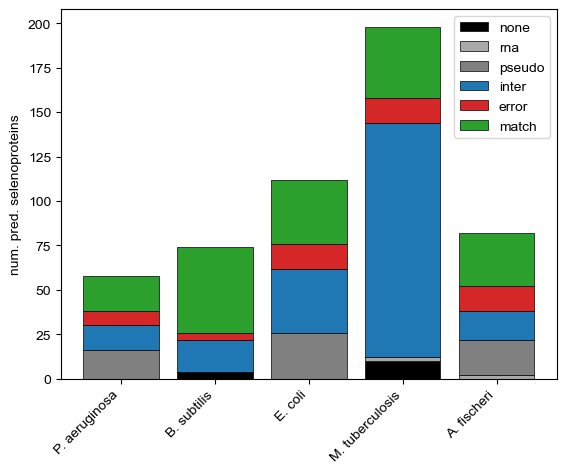

In [6]:
fig, ax = plt.subplots()

color_map = {'match':'tab:green', 'error':'tab:red', 'inter':'tab:blue', 'pseudo':'gray', 'rna':'darkgray', 'none':'black'}
labels = ['none', 'rna', 'pseudo', 'inter', 'error', 'match']
species = list(genome_ids.keys()) 

bottom = np.zeros(len(species))
for label in labels:
    label_df = pred_df[pred_df.label == label]
    heights = np.array([(label_df.species == s).sum() for s in species])
    ax.bar(np.arange(len(species)), heights, bottom=bottom, color=color_map[label], edgecolor='black', linewidth=0.5)
    bottom += heights

ax.set_xticks(np.arange(len(species)), labels=[f'{s.split()[0][0]}. {s.split()[-1]}' for s in species], rotation=45, ha='right')
ax.legend(labels)
ax.set_ylabel('num. pred. selenoproteins')
plt.show()

# I think a lot of the intergenic genes are probably pseudogenes... 


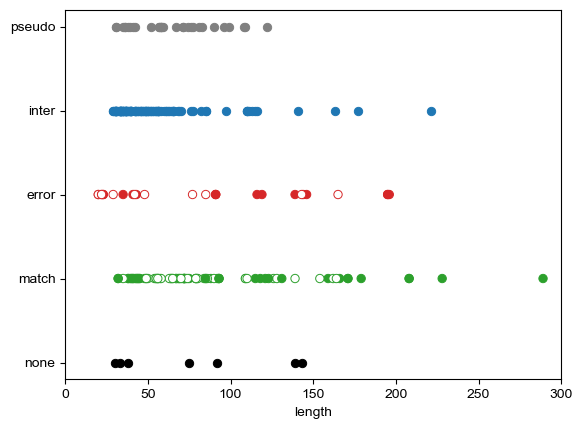

In [7]:
fig, ax = plt.subplots()

info_dfs = dict()
info_dfs['match'] = pd.concat([organism.get_match_info() for organism in organisms]) 
info_dfs['error'] = pd.concat([organism.get_error_info() for organism in organisms]) 

labels = ['none', 'match', 'error', 'inter', 'pseudo']
for i, label in enumerate(labels):
    df = pd.concat([organism.to_df(label=label) for organism in organisms]) 
    df = df[df.index.isin(pred_df.index)]

    color = color_map[label]
    if label in info_dfs:
        info_df = info_dfs[label]
        info_df = info_df[info_df.index.isin(df.index)]
        color = [color_map[label] if ('hypothetical' not in prod) else 'white' for prod in info_df['product']]

    ax.scatter(df.seq.apply(len), [i] * len(df), edgecolor=color_map[label], linewidths=0.7, color=color)

ax.set_xlim(0, 300)
ax.set_yticks(np.arange(len(labels)), labels=labels)
ax.set_xlabel('length')

plt.show()



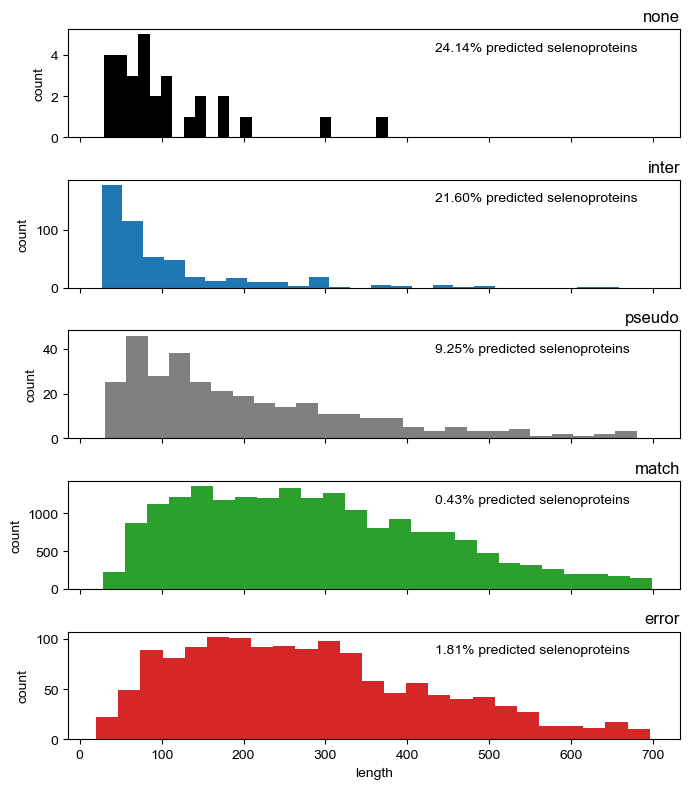

In [8]:
fig, axes = plt.subplots(nrows=5, figsize=(7, 8), sharex=True)

max_length = 700
labels = ['none', 'inter', 'pseudo', 'match', 'error']
for ax, label in zip(axes, labels):
    df = pd.concat([organism.to_df(label=label) for organism in organisms]) 

    p = f'{100 * df.index.isin(pred_df.index).sum() / len(df):.2f}% predicted selenoproteins'
    ax.text(0.6, 0.8, p, transform=ax.transAxes)

    lengths = df.seq.apply(len)
    lengths = lengths[lengths < max_length]
    ax.hist(lengths, color=color_map[label], bins=25)
    ax.set_ylabel('count')
    ax.set_title(label, loc='right')

ax.set_xlabel('length')
plt.tight_layout()
plt.show()

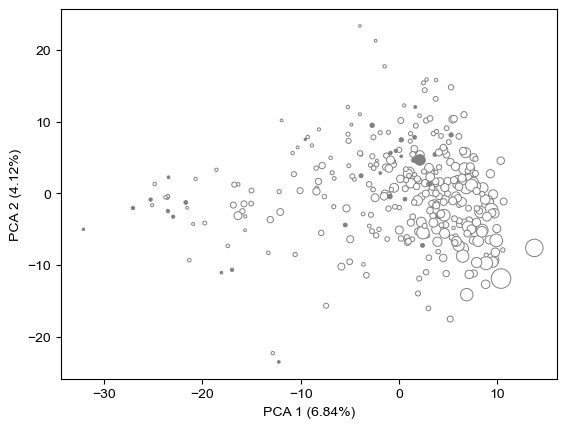

In [9]:
def load_embeddings(label:str):
    '''Load in the PLM embeddings which correspond to sequences with a specific label.'''
    ids = np.concatenate([organism.to_df(label=label).index for organism in organisms])

    emb_df = []
    seqs = []
    for organism in organisms:
        df = pd.read_hdf(f'../data/model_organisms/gtdb_{organism.code_name}.h5', key='plm')
        seq_df = pd.read_hdf(f'../data/model_organisms/gtdb_{organism.code_name}.h5', key='metadata')[['seq']]
        
        mask = df.index.isin(ids) 
        emb_df.append(df[mask])
        seqs += list(seq_df[mask].values.ravel())
    emb_df = pd.concat(emb_df)

    return emb_df, seqs



fig, ax = plt.subplots()

label = 'pseudo'
emb_df, seqs = load_embeddings(label)
emb, index = emb_df.values, emb_df.index

scaler = StandardScaler()
emb = scaler.fit_transform(emb)
pca = PCA(n_components=2)
comps = pca.fit_transform(emb)

exp_var = pca.explained_variance_ratio_
ax.set_xlabel(f'PCA 1 ({100 * exp_var[0]:.2f}%)')
ax.set_ylabel(f'PCA 2 ({100 * exp_var[1]:.2f}%)')

colors = [color_map[label] if id_ in pred_df.index else 'white' for id_ in index]
sizes = [len(seq) / 10 for seq in seqs]
ax.scatter(comps[:, 0], comps[:, 1], edgecolors=color_map[label], linewidth=0.7, color=colors, sizes=sizes)
plt.show()

